<h1>Tabular Playground Series - Mar 2021

<section id = 'top'></section>
<h2>
    <ol>
        <li><a href=#preda>Preliminary EDA</a></li>
        <li><a href=#csep>Visualizing Class Separation</a></li>
        <li><a href=#numdist>Distribution of Numeric Variables</a></li>
        <li><a href=#numvstgt>Numeric Variables vs Target</a></li>
        <li><a href=#catdist>Distribution of Categorical Variables</a></li>
        <li><a href=#catrel>Categorical Variables vs Target</a></li>
        <li><a href=#rare>Handling Rare Categories in Categorical Variables</a></li>
        <li><a href=#tgtdist>Target Distribution</a></li>
        <li><a href=#mutinfo>Mutual Information</a></li>
        <li><a href=#base>Random Forest Baseline Model</a></li>
        <li><a href=#nfc>New Feature Creation</a></li>
        <li><a href=#build>Model Building</a></li>
        <li><a href=#subm>Submission</a></li>
    </ol></h2>
        


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency 
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, MaxAbsScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from imblearn import under_sampling
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from lightgbm import LGBMClassifier
import optuna
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
import warnings
warnings.filterwarnings("ignore")

<h1><section id="preda">1. Preliminary EDA&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

In [2]:
data = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')

In [3]:
data.head().T

,0,1,2,3,4
id,0,1,2,3,4
cat0,A,A,A,A,A
cat1,I,I,K,K,I
cat2,A,A,A,A,G
cat3,B,A,A,C,B
cat4,B,E,E,E,E
cat5,BI,BI,BI,BI,BI
cat6,A,K,A,A,C
cat7,S,W,E,Y,G
cat8,Q,AD,BM,AD,Q


In [4]:
data.shape

(300000, 32)

<h3>Dropping 'id' column

In [5]:
data.drop(columns='id',inplace=True)

In [6]:
data.dtypes

cat0       object
cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
cat6       object
cat7       object
cat8       object
cat9       object
cat10      object
cat11      object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cont0     float64
cont1     float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     float64
cont7     float64
cont8     float64
cont9     float64
cont10    float64
target      int64
dtype: object

<h3>Data type of all the variables looks good.</h3><br>
<h2>Storing Categorical, Numeric and Target variables in separate variables for simpler EDA

In [7]:
categorical_variables = list(data.select_dtypes('object').columns)

numeric_variables = list(data.select_dtypes('float64').columns)

target = list(data.select_dtypes('int64').columns)[0]

print(f'Categorical Variables ({len(categorical_variables)}):\n{categorical_variables}\n\nNumeric Variables ({len(numeric_variables)}):\n{numeric_variables}\n\nTarget:\n{target}')

Categorical Variables (19):
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

Numeric Variables (11):
['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

Target:
target


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cont0,300000.0,0.504749,0.206788,-0.049562,0.344985,0.479650,0.637657,1.004559
cont1,300000.0,0.494073,0.213037,0.084480,0.317363,0.463170,0.693992,1.009958
cont2,300000.0,0.516632,0.214851,0.094493,0.326047,0.471247,0.704625,1.016600
cont3,300000.0,0.474235,0.216636,-0.045316,0.292249,0.387564,0.644950,0.952187
cont4,300000.0,0.504848,0.227474,0.168071,0.279303,0.479858,0.725779,0.858578
cont5,300000.0,0.502257,0.241243,-0.036379,0.276442,0.554768,0.735225,0.853022
cont6,300000.0,0.488229,0.211335,0.005199,0.323914,0.518089,0.608537,0.966553
cont7,300000.0,0.501739,0.203496,0.090901,0.353054,0.435404,0.642023,1.035818
cont8,300000.0,0.488074,0.179048,0.024139,0.358915,0.410908,0.612725,1.055885
cont9,300000.0,0.469496,0.194516,0.214866,0.309934,0.407477,0.586793,1.005652


<h3>No numeric variable has 0 as minimum, hence ruling out the presence of masked NaNs. No numeric varable has missing values</h3>

<h2>Checking for zero/near-zero variance in relation with the median for a clearer picture

In [9]:
data[numeric_variables].apply(lambda x: (x.std()/x.median())*100)

cont0     43.112158
cont1     45.995352
cont2     45.591998
cont3     55.896857
cont4     47.404435
cont5     43.485393
cont6     40.791188
cont7     46.737278
cont8     43.573851
cont9     47.736762
cont10    45.544990
dtype: float64

<h3>No numeric variable has zero/near-zero variance</h3><br>
<h2>Checking for Missing Values

In [10]:
data.isnull().mean()

cat0      0.0
cat1      0.0
cat2      0.0
cat3      0.0
cat4      0.0
cat5      0.0
cat6      0.0
cat7      0.0
cat8      0.0
cat9      0.0
cat10     0.0
cat11     0.0
cat12     0.0
cat13     0.0
cat14     0.0
cat15     0.0
cat16     0.0
cat17     0.0
cat18     0.0
cont0     0.0
cont1     0.0
cont2     0.0
cont3     0.0
cont4     0.0
cont5     0.0
cont6     0.0
cont7     0.0
cont8     0.0
cont9     0.0
cont10    0.0
target    0.0
dtype: float64

<h3>No missing values</h3>

<h1><section id='csep'>2. Visualizing Class Separation&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h2>We'll reduce the dimensionality of the data using PCA/SVD to get a rough idea on how the classes are separated.<br><br>First using ordinal encoding for categorical variables and using PCA

In [11]:
X = data.iloc[:,:-1].copy()
y = data['target'].astype(np.int8).copy()

col_transform = ColumnTransformer(transformers=[['ordinal_encoder',OrdinalEncoder(),categorical_variables]],remainder='passthrough')

X = col_transform.fit_transform(X).copy()
min_max = MinMaxScaler()
X = min_max.fit_transform(X).copy()

pca = PCA(n_components=2,random_state=11)
X_pca = pca.fit_transform(X).copy()
X_pca = pd.DataFrame(X_pca,columns=["component_1","component_2"])
X_pca['y'] = y

np.cumsum(pca.explained_variance_ratio_)

array([0.19360206, 0.3288066 ])

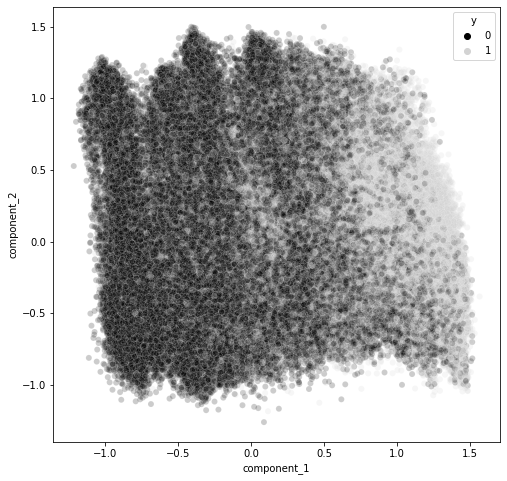

In [12]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=X_pca,x='component_1',y="component_2",hue='y',alpha=0.2,palette=['black','lightgray']);

<h3>Though the explained variance of PCA is low, the plot above gives us a fair idea (not very much reliable) that the classes are fairly separated. Let's try SVD

<h2>Let's one hot encode categorical variables and use Truncated SVD on the sparse data

In [13]:
X = data.iloc[:,:-1].copy()
y = data['target'].astype(np.int8).copy()

col_transform = ColumnTransformer(transformers=[['ohe',OneHotEncoder(),categorical_variables]],remainder='passthrough')

X = col_transform.fit_transform(X).copy()
max_abs = MaxAbsScaler()
X = max_abs.fit_transform(X).copy()

tsvd = TruncatedSVD(n_components=2,random_state=11)
X_svd = tsvd.fit_transform(X).copy()
X_svd = pd.DataFrame(X_svd,columns=["component_1","component_2"])
X_svd['y'] = y

np.cumsum(tsvd.explained_variance_ratio_)

array([0.01621324, 0.12503217])

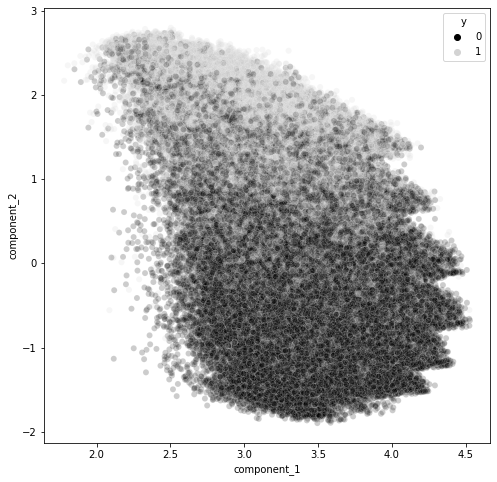

In [14]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=X_svd,x='component_1',y="component_2",hue='y',alpha=0.2,palette=['black','lightgray']);

<h3>Both PCA and SVD show that the classes are fairly separated (though they are not reliable due to very low explained variance, they give us a fair idea). Trying it after feature engineering may result in better explained variance ratio.

<h1><section id='numdist'>3. Distribution of Numeric Variables&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

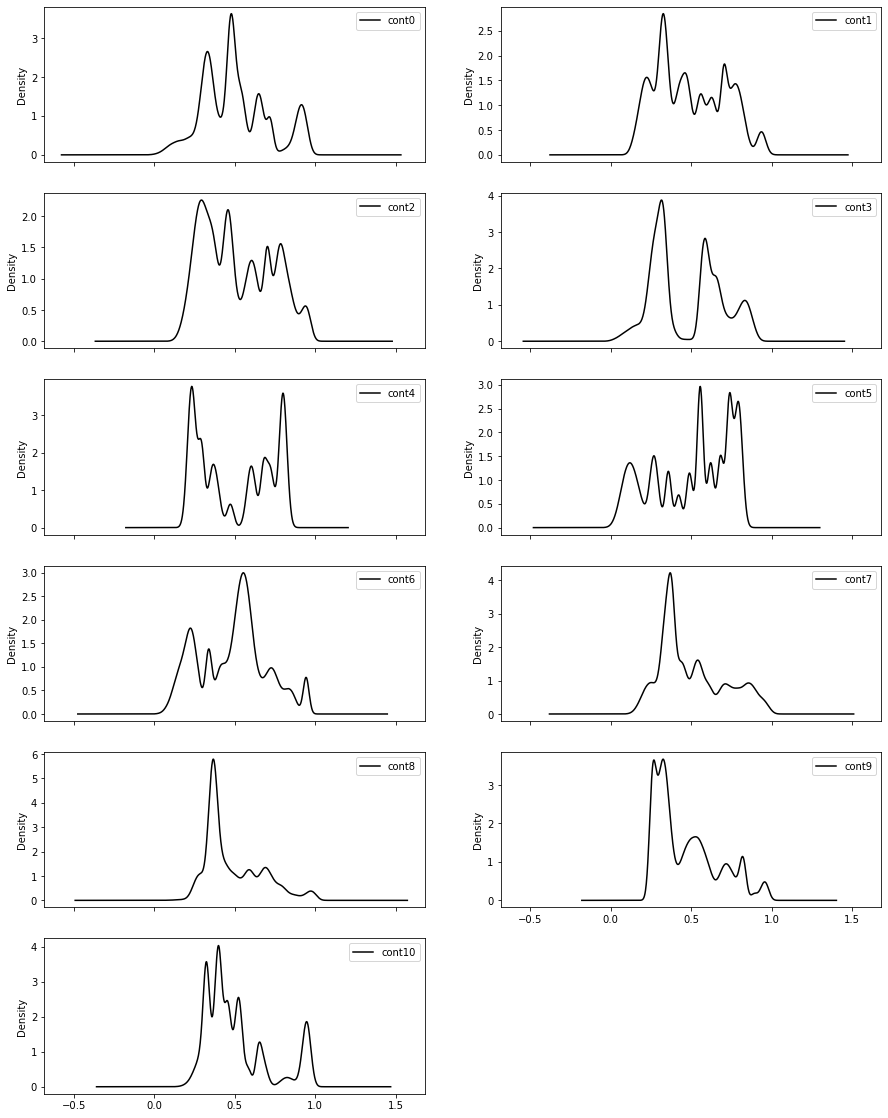

In [15]:
data[numeric_variables].plot(kind='kde',figsize=(15,20),subplots=True,layout=(6,2),color='black');

<h3>Few variables have multiple peaks in their distribution and almost all of them look skewed. However, a statistical test can confirm these observations

<h2>Normality Test

In [16]:
print("h0:Sample comes from a normal distribution\nh1:Sample doesn't come from a normal distribution\n\n")

for i in numeric_variables:
    print(f"{i}: {'Non-Gaussian' if (stats.normaltest(data[i])[1])<0.05 else 'Gaussian'}")

h0:Sample comes from a normal distribution
h1:Sample doesn't come from a normal distribution


cont0: Non-Gaussian
cont1: Non-Gaussian
cont2: Non-Gaussian
cont3: Non-Gaussian
cont4: Non-Gaussian
cont5: Non-Gaussian
cont6: Non-Gaussian
cont7: Non-Gaussian
cont8: Non-Gaussian
cont9: Non-Gaussian
cont10: Non-Gaussian


<h2>Q-Q plots

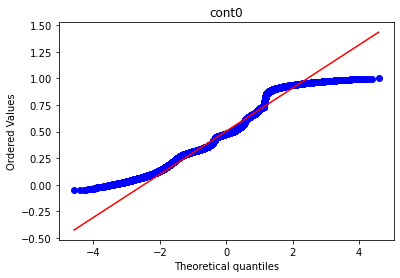

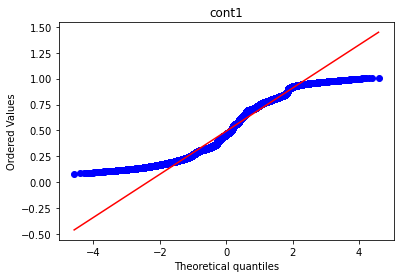

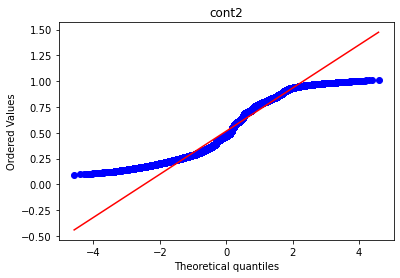

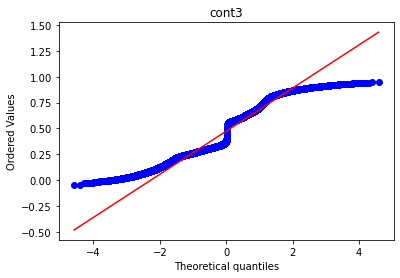

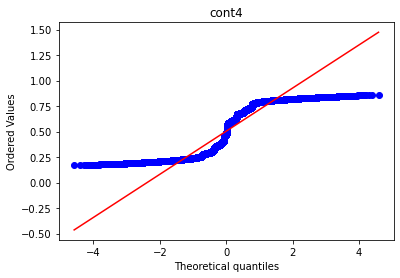

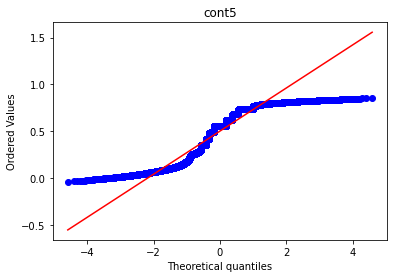

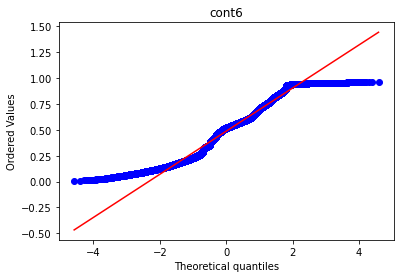

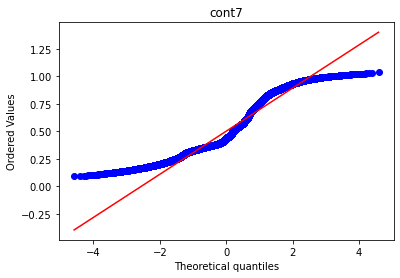

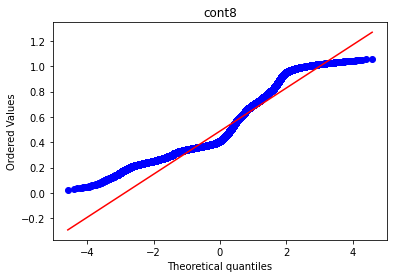

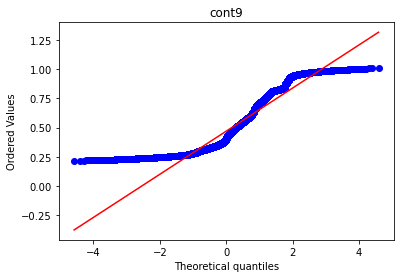

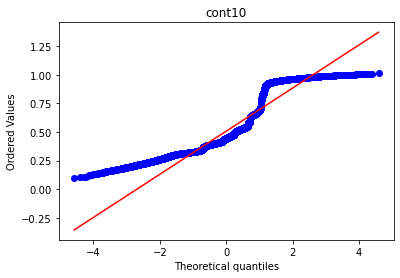

In [17]:
for n,i in enumerate(numeric_variables):
    stats.probplot(data[i],plot=plt)
    plt.title(i)
    plt.show()

<h3>No numeric variable has a Gaussian/Normal Distribution

<h2>Box Plot for outlier detection

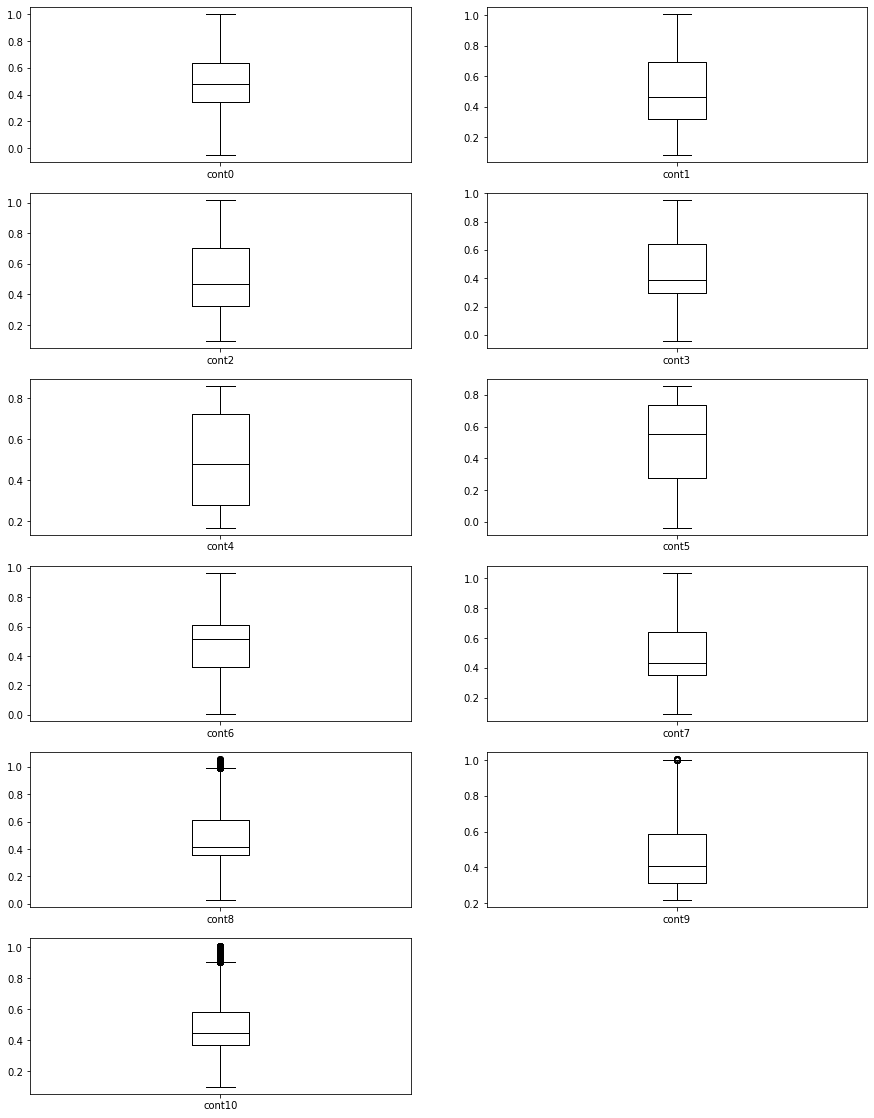

In [18]:
data[numeric_variables].plot(kind='box',subplots=True,layout=(6,2),figsize=(15,20),color='black');

<h3>Variables cont8, cont9, cont10 have outliers</h3><br>
<h2>Skewness test

In [19]:
for i in numeric_variables:
    print(f"{i}: {'Skewed' if (stats.skewtest(data[i])[1])<0.05 else 'Not Skewed'}  {stats.skew(data[i])}")

cont0: Skewed  0.47803404288917006
cont1: Skewed  0.2689453477655588
cont2: Skewed  0.31713677340991825
cont3: Skewed  0.22297872631846266
cont4: Skewed  0.05670456799629283
cont5: Skewed  -0.41835454164640967
cont6: Skewed  0.08538828017207528
cont7: Skewed  0.6520411173657187
cont8: Skewed  0.9268857745621815
cont9: Skewed  0.8092431988589172
cont10: Skewed  1.0877699310392652


<h3>cont7, cont8, cont9 & cont10 have slightly higher right-skewness. Other variables have slight skewness (cont5 is slightly left-skewed)

<h2>Relationship among numeric variables

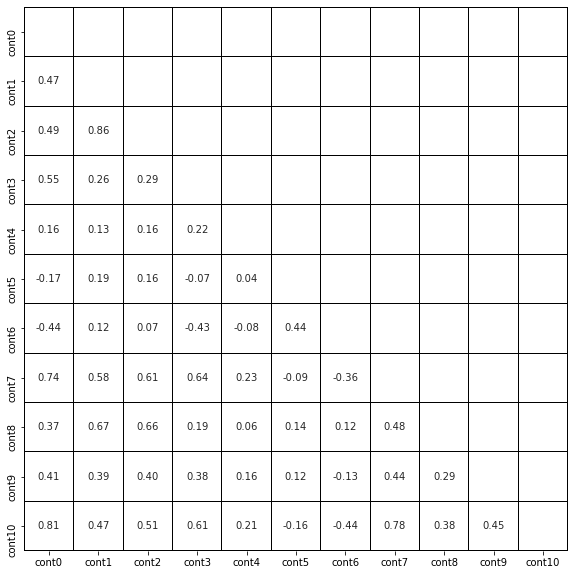

In [20]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(data[numeric_variables].corr(),mask=np.triu(data[numeric_variables].corr()),
            annot=True,fmt='.2f',
            cbar=False,cmap=['white'],linewidths=0.01,linecolor='black',square=True);

<h3>Few numeric features are highly correlated with each other

<h1><section id='numvstgt'>4. Numeric Variables vs Target&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

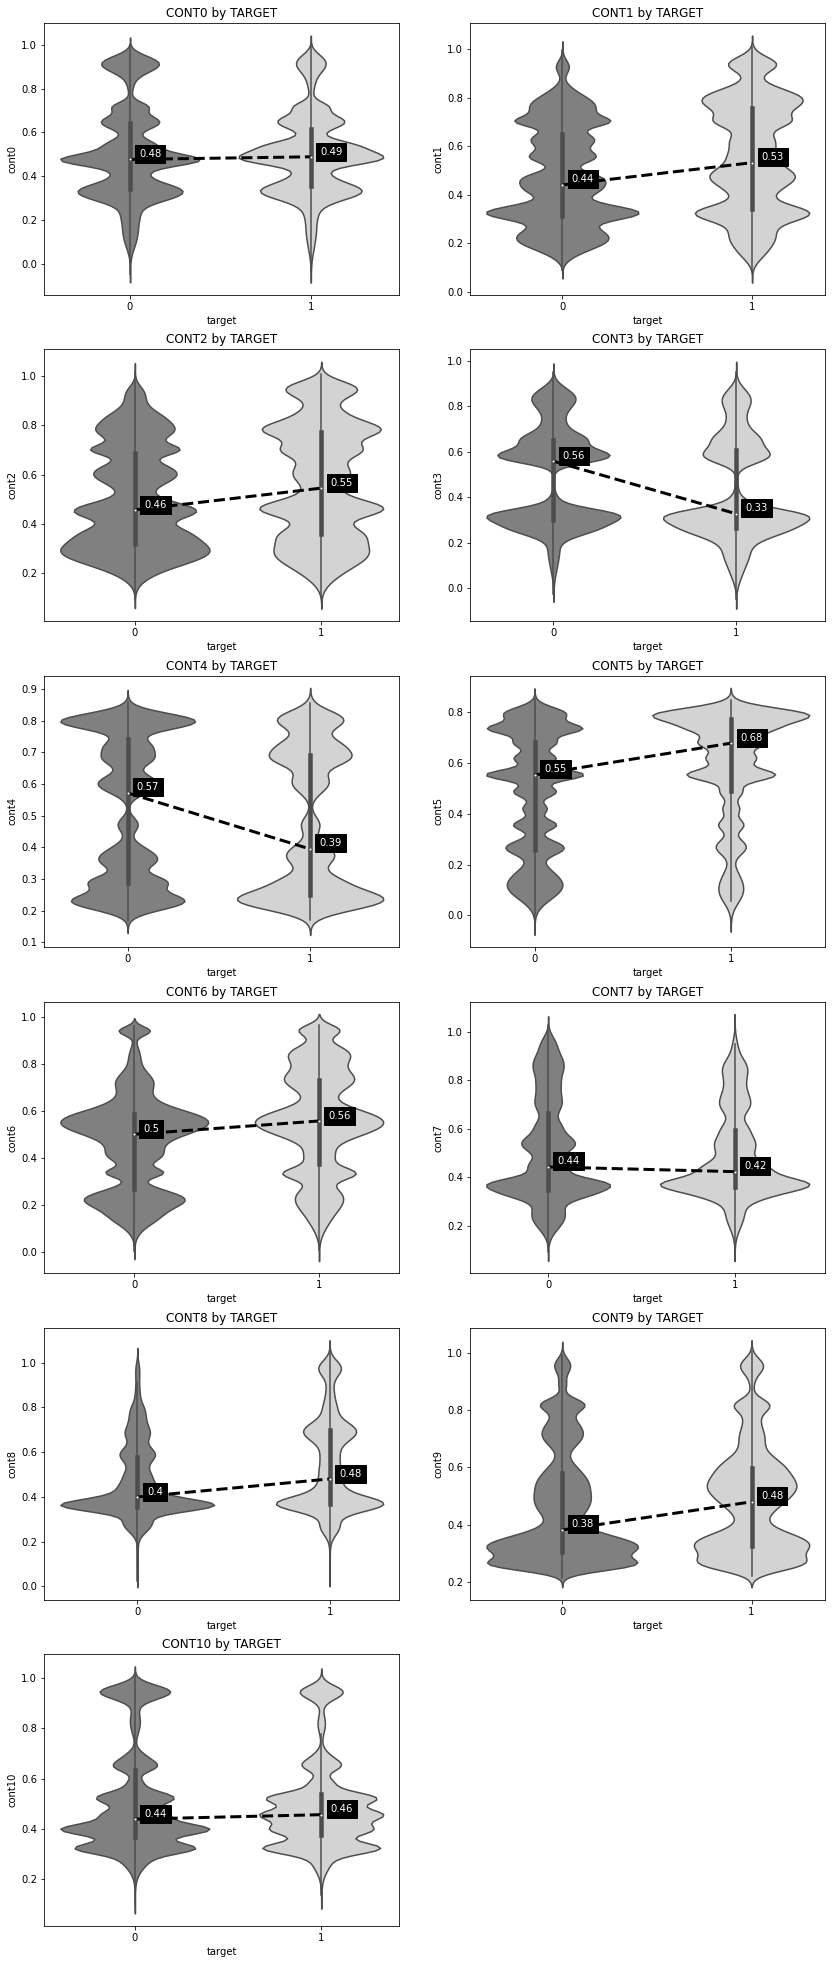

In [21]:
r = c = 0
fig,ax = plt.subplots(6,2,figsize=(14,35))
for n,i in enumerate(numeric_variables):
    med = data[[i,'target']].groupby('target').median().copy()
    sns.violinplot(x=target,y=i,data=data,ax=ax[r,c],palette=["gray","lightgray"])
    med.plot(ax=ax[r,c],color='black',linewidth=3,linestyle="--",legend=False)
    for x,y in zip(list(med.index),med[i]):
        ax[r,c].text(x=x+0.05,y=y+0.01,s=np.round(y,2),fontsize=10,color='white',backgroundcolor='black')
    ax[r,c].set_title(i.upper()+" by "+"TARGET")
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

<h3>Most of the continous variables have a similar distribution for both the classes of target variables. However, their median shows some sort of relationship with the target.

<h1><section id='catdist'>5. Distribution of Categorical Variables&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

In [22]:
for i in categorical_variables:
    val_cnt = pd.DataFrame(np.round(data[i].value_counts(normalize=True)*100,2))
    val_cnt.columns = ['Proportion']
    print(f'{i}: {data[i].nunique()} unique categories\n{val_cnt}\n')

cat0: 2 unique categories
   Proportion
A       74.51
B       25.49

cat1: 15 unique categories
   Proportion
I       30.27
F       14.61
K       13.96
L       10.63
H        5.75
N        4.41
M        3.78
G        3.75
A        3.52
J        3.35
O        2.91
B        2.28
C        0.57
D        0.14
E        0.08

cat2: 19 unique categories
   Proportion
A       56.23
C       12.96
D        7.57
G        6.08
Q        3.63
F        3.29
J        3.03
M        2.69
I        1.76
L        1.33
O        0.92
N        0.11
H        0.07
B        0.07
S        0.07
U        0.06
R        0.04
K        0.04
E        0.04

cat3: 13 unique categories
   Proportion
A       62.42
B       26.65
C        5.32
D        2.89
E        1.11
F        0.83
K        0.28
G        0.12
L        0.10
J        0.10
H        0.09
I        0.06
N        0.04

cat4: 20 unique categories
   Proportion
E       43.13
F       25.56
G       10.25
D        9.31
H        7.80
J        1.44
I        1.08
K       

<h2>Few categorical variables have high cardinality therefore, rare labels.

<h1><section id='catrel'>6. Categorical Variables vs Target&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

In [23]:
for i in categorical_variables:
    ct = pd.crosstab(columns=data[i],index=data["target"])
    stat, p, dof, expected = chi2_contingency(ct) 
    print(f"\n{'-'*len(f'Chi-Square test between {i} & Target')}")
    print(f'Chi-Square test between {i} & Target')
    print(f"{'-'*len(f'Chi-Square test between {i} & Target')}")
    print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN TARGET & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN TARGET & {i.upper()}")
    print(f"\nP-VALUE: {np.round(p,2)}")
    print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")


-------------------------------------
Chi-Square test between cat0 & Target
-------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN TARGET & CAT0
H1: THERE IS RELATIONSHIP BETWEEN TARGET & CAT0

P-VALUE: 0.0
REJECT H0

-------------------------------------
Chi-Square test between cat1 & Target
-------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN TARGET & CAT1
H1: THERE IS RELATIONSHIP BETWEEN TARGET & CAT1

P-VALUE: 0.0
REJECT H0

-------------------------------------
Chi-Square test between cat2 & Target
-------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN TARGET & CAT2
H1: THERE IS RELATIONSHIP BETWEEN TARGET & CAT2

P-VALUE: 0.0
REJECT H0

-------------------------------------
Chi-Square test between cat3 & Target
-------------------------------------

H0: THERE IS NO RELATIONSHIP BETWEEN TARGET & CAT3
H1: THERE IS RELATIONSHIP BETWEEN TARGET & CAT3

P-VALUE: 0.0
REJECT H0

-------------------------------------
Chi-S

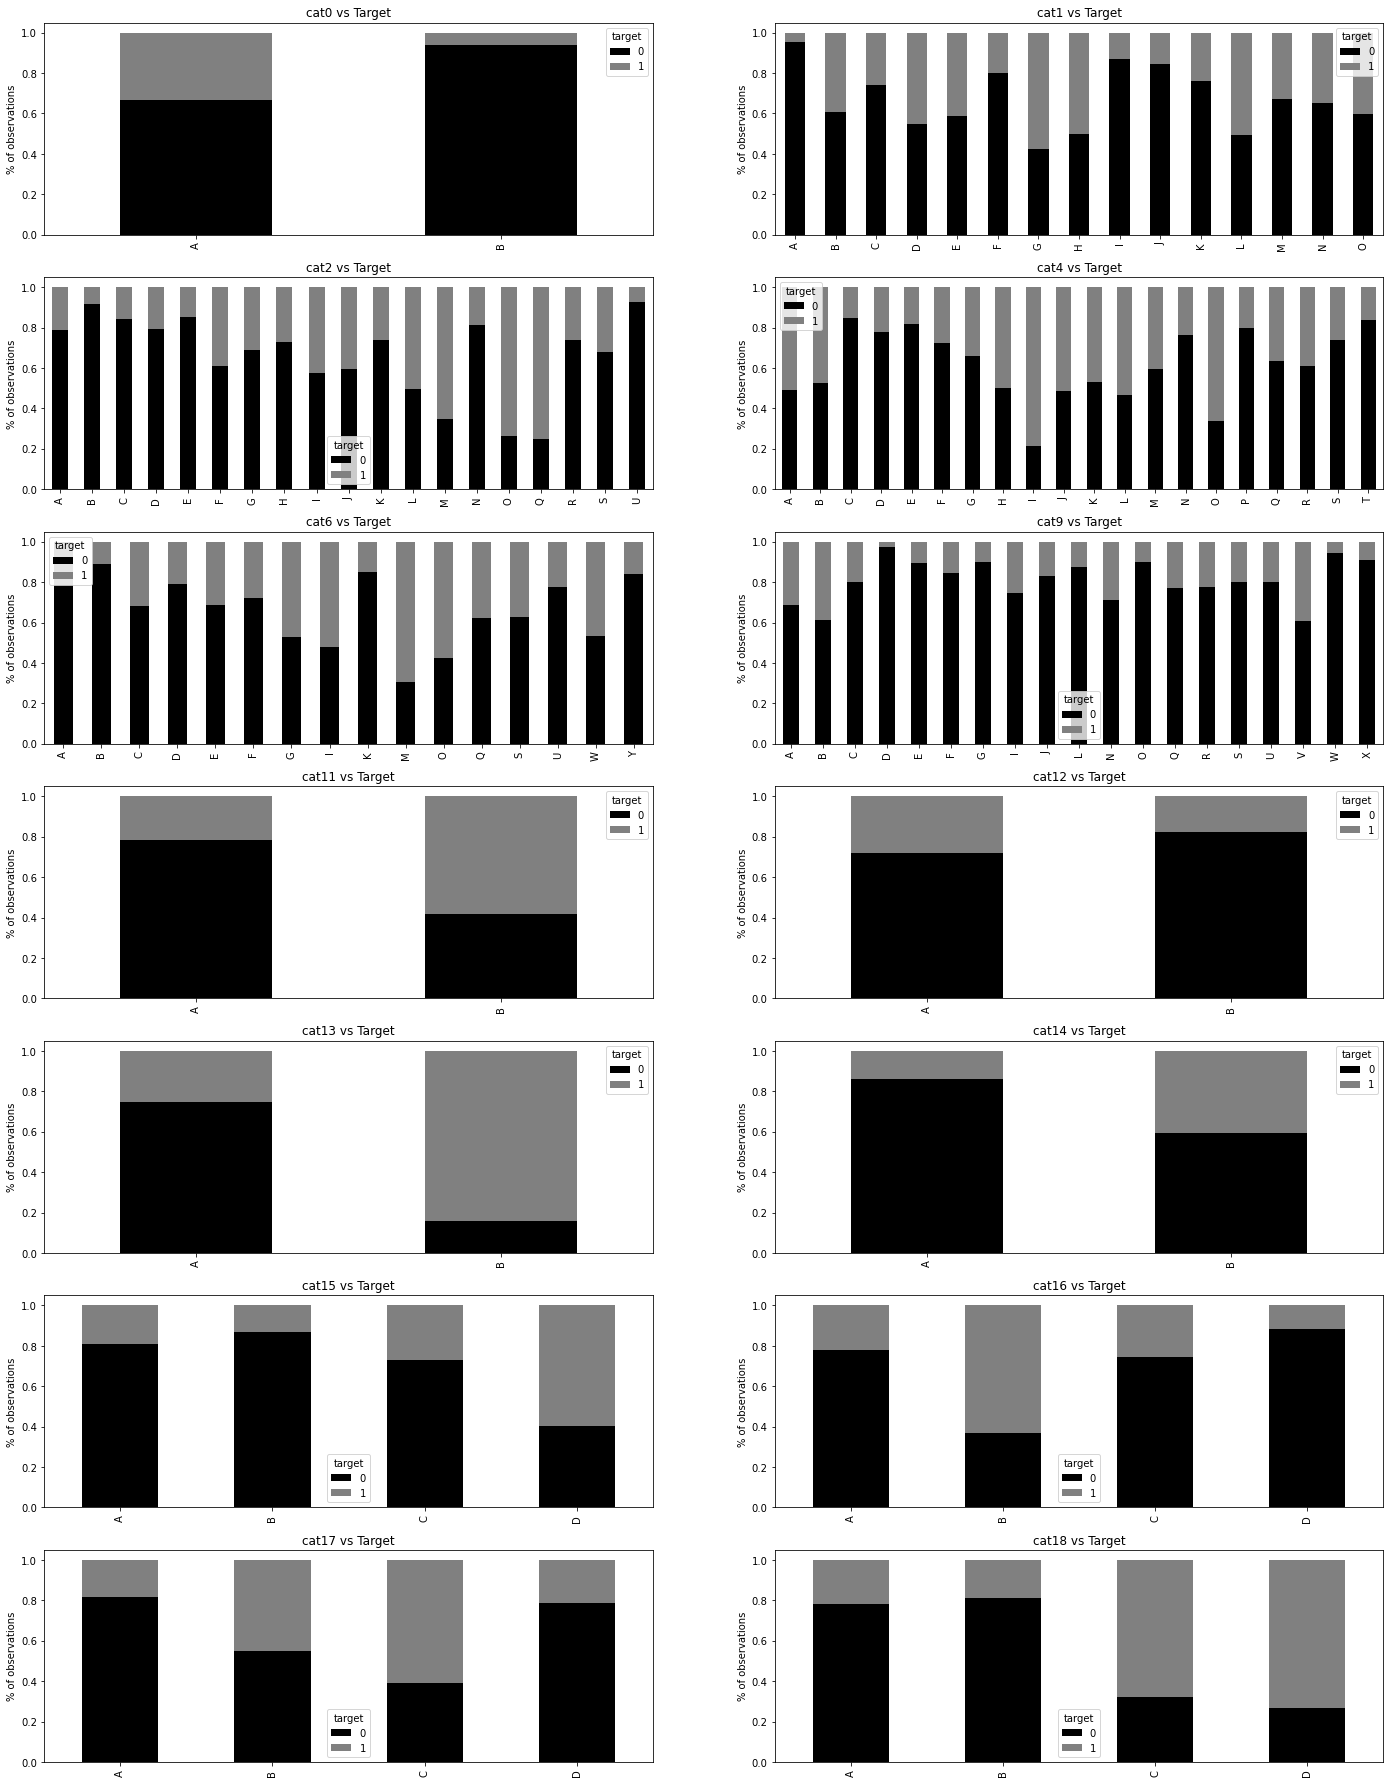

In [24]:
r = c = 0
fig,ax = plt.subplots(7,2,figsize=(24,32))
new_cat = categorical_variables.copy()
new_cat.remove('cat3')
new_cat.remove('cat10')
new_cat.remove('cat5')
new_cat.remove('cat7')
new_cat.remove('cat8')
for n,i in enumerate(new_cat):
    ct = pd.crosstab(columns=data[i],index=data['target'],normalize="columns")
    ct.T.plot(kind="bar",stacked=True,color=["black","gray"],ax=ax[r,c])
    ax[r,c].set_ylabel("% of observations")
    ax[r,c].set_xlabel("")
    ax[r,c].set_title(f'{i} vs Target')
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
plt.show()

<h3>Excluded few plots as they were cluttered.

<h1><section id='rare'>7. Handling Rare Categories in Categorical Variables&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h2>Identifying non-rare categories in category variables with different cut-offs for each variable and saving them in a csv.

In [25]:
non_rare = pd.DataFrame()

cut_offs = [0.2,0.02,0.02,0.02,0.02,0.03,0.01,0.01,0.005,0.02,0.001,0.1,0.1,0.02,0.4,0.04,0.02,0.085,0.072]

for n,i in enumerate(categorical_variables):
    var_dist = data[i].value_counts(normalize=True).copy()
    non_rare = pd.concat([non_rare,pd.DataFrame({i:var_dist[var_dist>cut_offs[n]].index})],axis=1).copy()

non_rare.to_csv('./non_rare_categories.csv',index=False) #storing non-rare categories in a csv for further use
non_rare

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18
0,A,I,A,A,E,BI,A,AH,BM,A,DJ,A,A,A,A,B,D,D,B
1,B,F,C,B,F,AB,C,E,AE,E,HK,B,B,B,B,D,B,B,D
2,NaN,K,D,C,G,NaN,E,AS,AX,C,DP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,L,G,D,D,NaN,G,J,Y,F,GS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,H,Q,NaN,H,NaN,I,AN,H,J,CR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Plotting categorical variables before and after marking rare categories

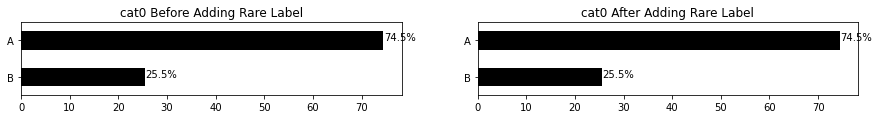

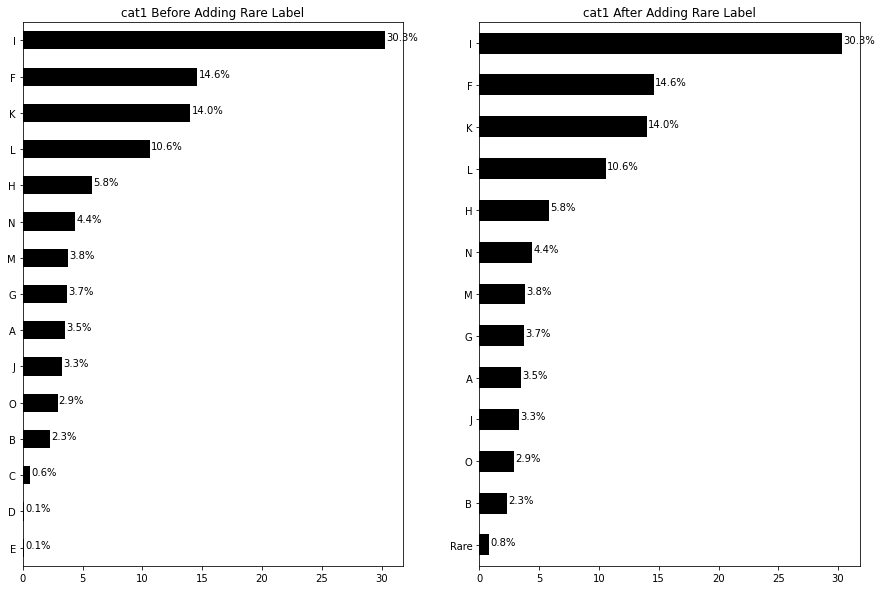

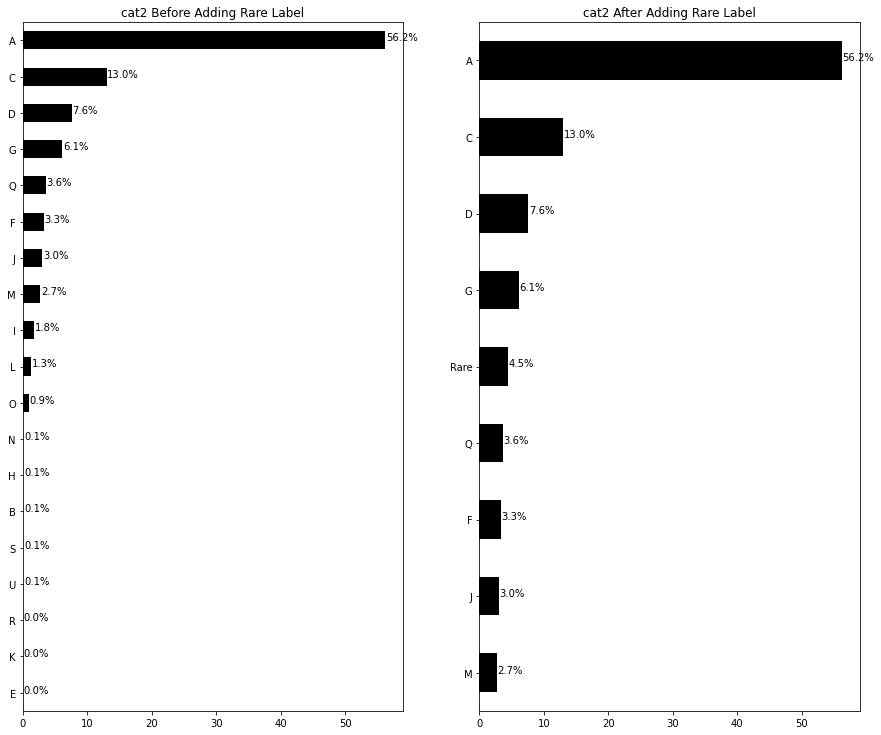

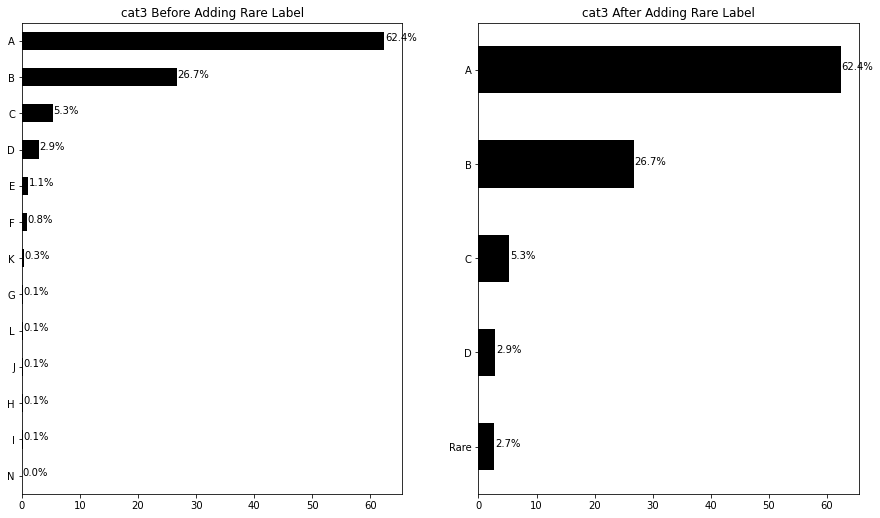

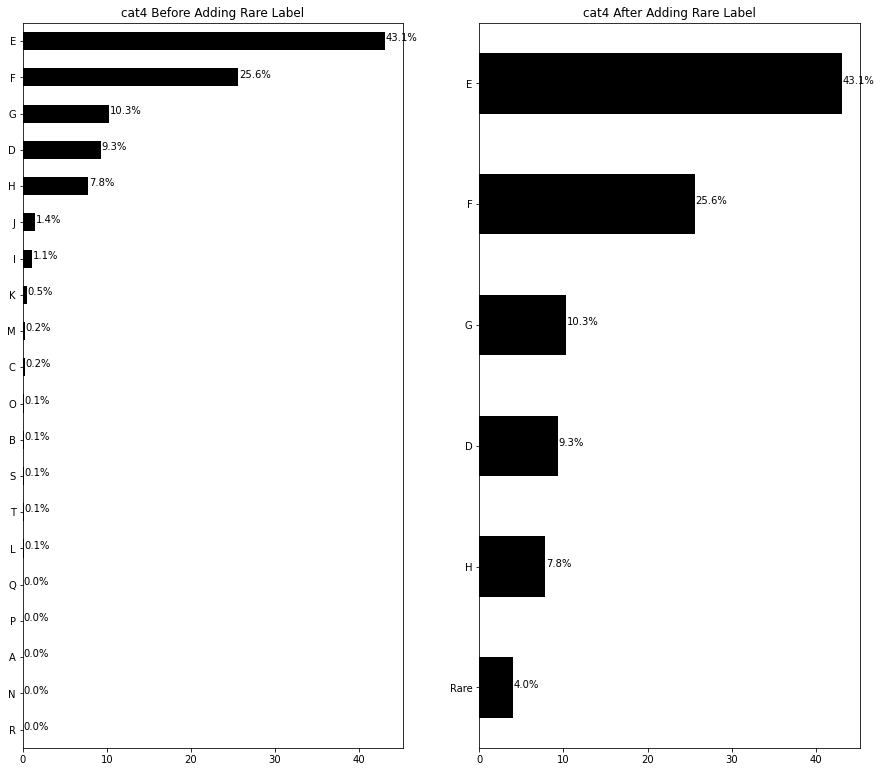

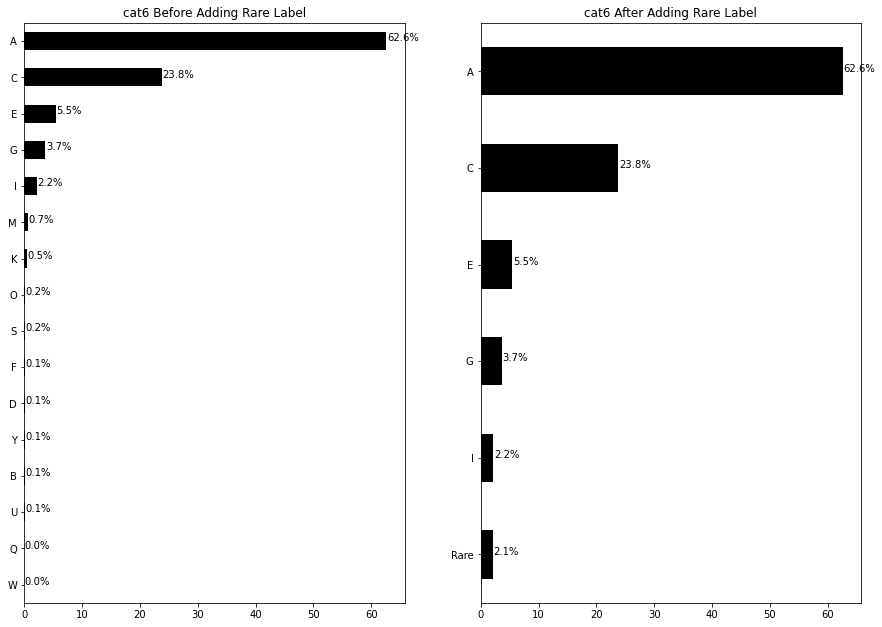

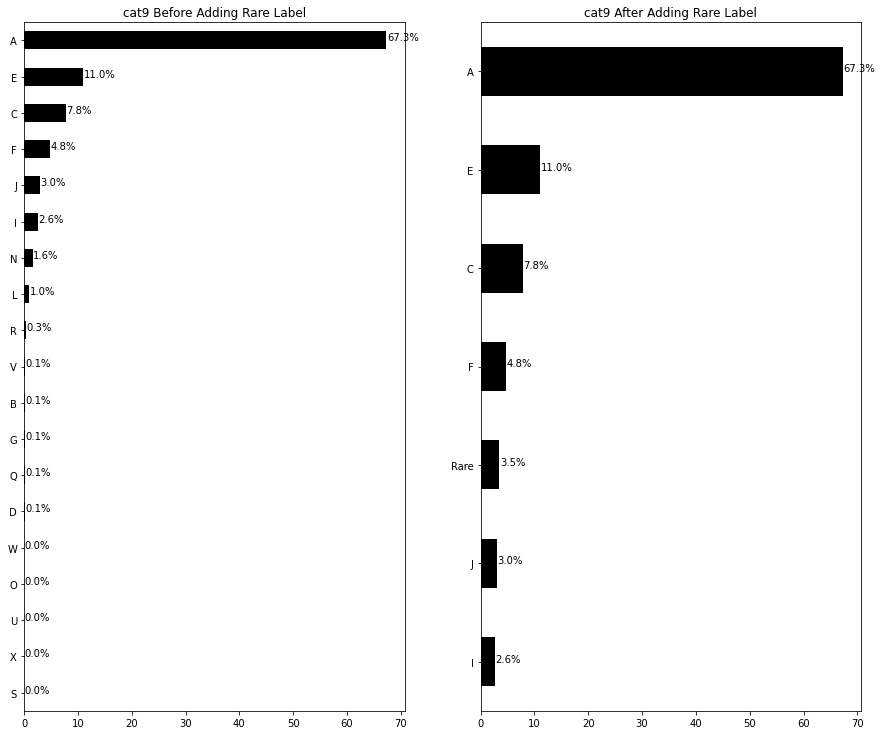

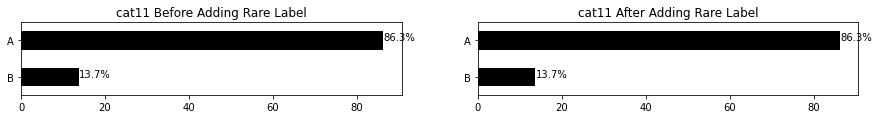

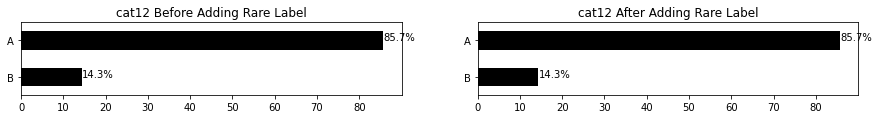

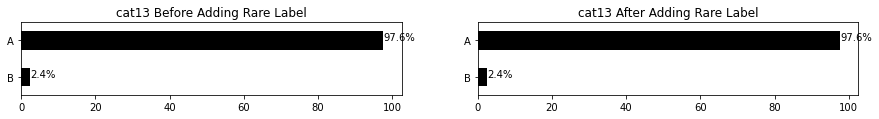

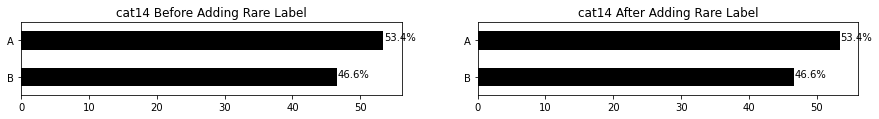

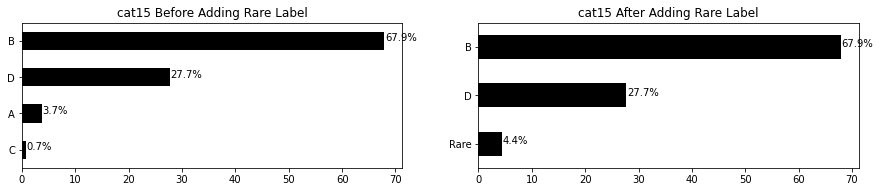

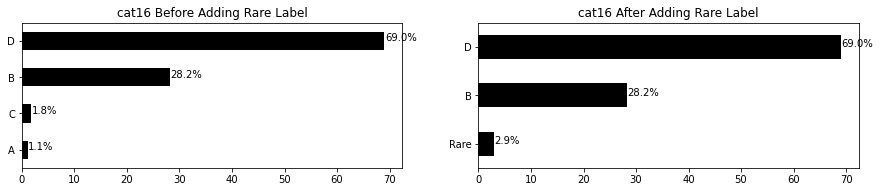

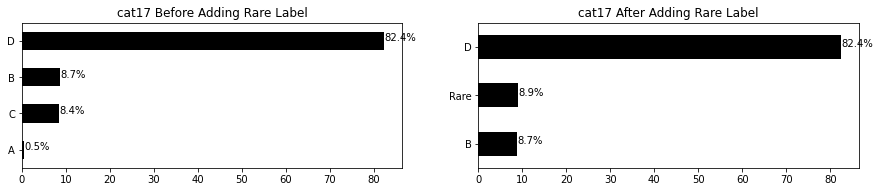

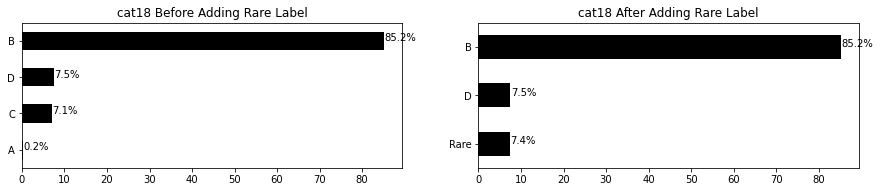

In [26]:
new_data = data.copy()
for i in non_rare.columns:
    new_data.loc[(new_data[i].isin(non_rare[i]) == False), i] = "Rare"
    
    

for n,i in enumerate(non_rare.columns):
    if i in ['cat5', 'cat7', 'cat8', 'cat10']:
        continue
    
    cat_dist = data[i].value_counts().sort_values().copy()
    cat_dist = np.round((cat_dist / cat_dist.sum()) * 100,1).copy()
    fig,ax = plt.subplots(1,2,figsize=(15, len(cat_dist)/1.5))
    cat_dist.plot(kind="barh",ax=ax[0],sharey=False,title=i + " Before Adding Rare Label",color='black')
    for n,j in enumerate(cat_dist.index):
        ax[0].text(y=n,x=cat_dist[j]+0.1,s=str(cat_dist[j]) + "%")
    
    
    new_cat_dist = new_data[i].value_counts().sort_values().copy()
    new_cat_dist = np.round((new_cat_dist / new_cat_dist.sum()) * 100,1).copy()
    new_cat_dist.plot(kind="barh",ax=ax[1],sharey=False,title=i + " After Adding Rare Label",color='black')
    for n,j in enumerate(new_cat_dist.index):
        ax[1].text(y=n,x=new_cat_dist[j]+0.1,s=str(new_cat_dist[j]) + "%")
    
    
plt.show()

<h3>Plots of few variables with high cardinality as hidden

<h3>Defining a function to mark rare labels

In [27]:
def mark_rare_categories(df):
    df = df.copy()
    non_rare = pd.read_csv('./non_rare_categories.csv')
    for i in non_rare.columns:
        df.loc[(df[i].isin(non_rare[i]) == False), i] = "Rare"
    return df

<h1><section id='tgtdist'>8. Target Distribution&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

In [28]:
data[target].unique()

array([0, 1])

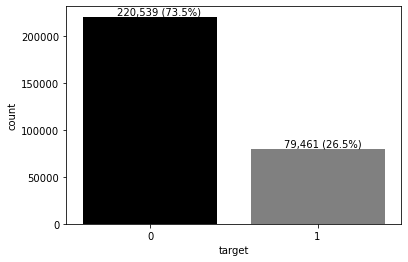

In [29]:
sns.countplot(data=data,x=target,palette=['black','gray']);

tgt_cnt = data[target].value_counts()

tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)

plt.text(x=-0.2,y=tgt_cnt[0]+2500,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)')

plt.text(x=0.8,y=tgt_cnt[1]+3000,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)');

<h3>Class in imbalanced

<h1><section id='mutinfo'>9. Mutual Information&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h3>Calculating mutual information scores with and without marking rare categories. This helps in understanding the effect of marking rare categories

In [30]:
def mutual_info(df,mark_rare=False):
    df = df.copy()
    if mark_rare == True:
        df = mark_rare_categories(df).copy()
    
    #X = df.iloc[:,:-1].copy()
    X = df.drop(columns=['target']).copy()
    y = df['target'].values.copy()

    for i in categorical_variables:
        le = LabelEncoder()
        X[i] = le.fit_transform(X[i])

    mutual_info = mutual_info_classif(X=X,y=y,discrete_features=(X.dtypes == np.int64),random_state=11)
    mutual_info_df = pd.DataFrame({'feature':X.columns,'MI':mutual_info}).sort_values(by='MI',ascending=False)
    mutual_info_df.sort_values(by='MI').plot(x='feature',y='MI',kind='barh',figsize=(15,12),color='black')
    for n,k in enumerate(range((len(mutual_info_df)-1),-1,-1)):
        plt.text(y=n-0.2,x=mutual_info_df.iloc[k,1],s=np.round(mutual_info_df.iloc[k,1],4))
    plt.show()
    if mark_rare == True:
        mutual_info_df.columns = ['Feature','MI_mark_rare_T']
    else:
        mutual_info_df.columns = ['Feature','MI_mark_rare_F']
    return mutual_info_df

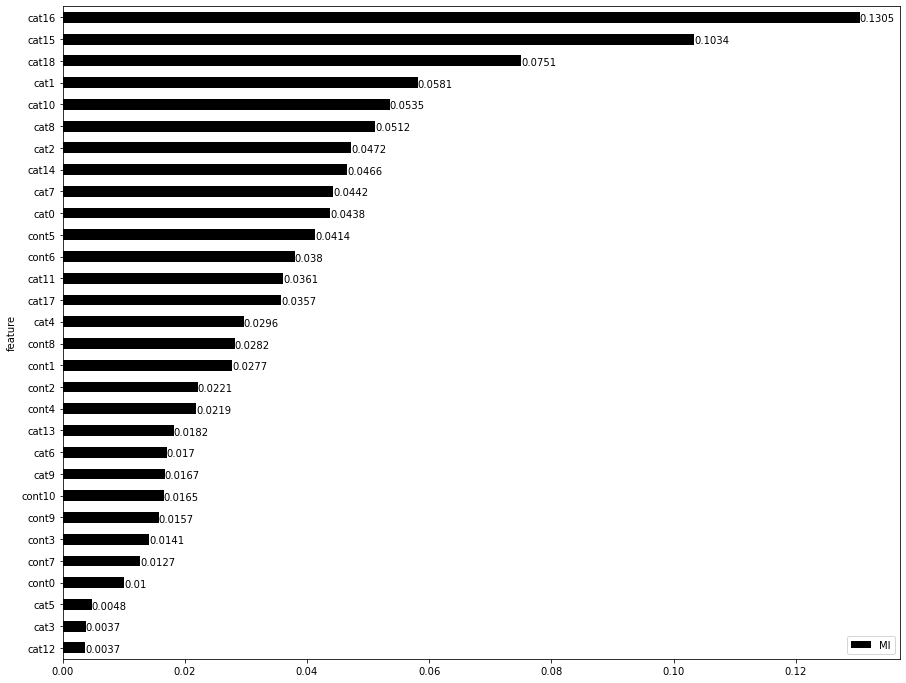

In [31]:
mi_mark_rare_F = mutual_info(data).copy()

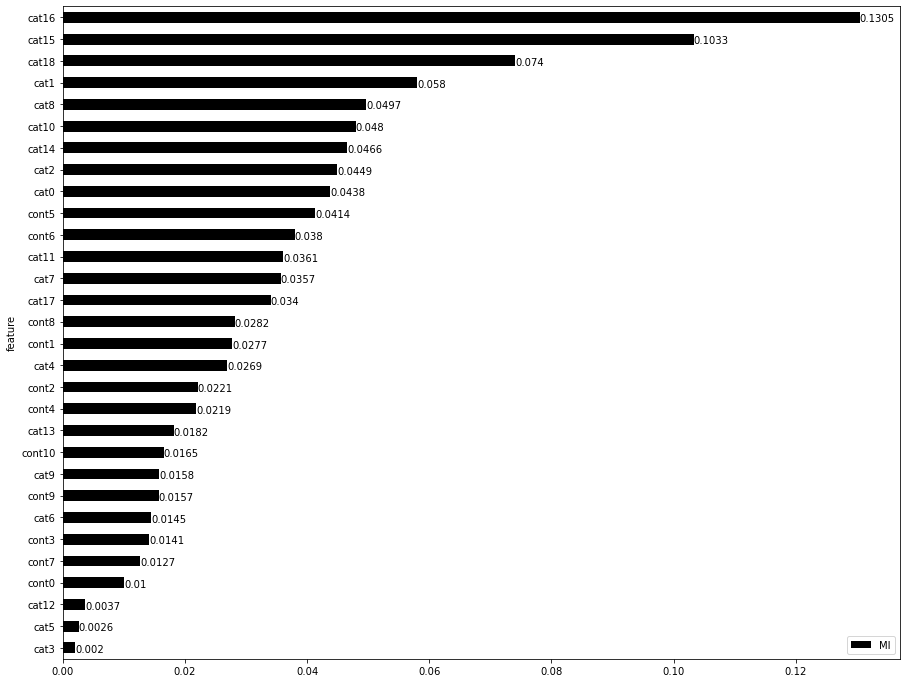

In [32]:
mi_mark_rare_T = mutual_info(df=data,mark_rare=True).copy()

<h3>From the above MI plots, we need to assess if marking rare lables is resulting in any loss of information

In [33]:
marked_rare_cols = mark_rare_categories(data).copy()
marked_rare_cols = (((marked_rare_cols[categorical_variables] == 'Rare').sum()).astype('bool')).reset_index()
marked_rare_cols.columns = ['Feature','is_marked_rare']

mi_mark_rare_F = mi_mark_rare_F.merge(mi_mark_rare_T,on='Feature',how='left').copy()
mi_mark_rare_F = mi_mark_rare_F.merge(marked_rare_cols,on='Feature',how='left').copy()

mi_mark_rare_F['mi_percent_change'] = (mi_mark_rare_F['MI_mark_rare_T'] / mi_mark_rare_F['MI_mark_rare_F'] -1)*100
mi_mark_rare_F

,Feature,MI_mark_rare_F,MI_mark_rare_T,is_marked_rare,mi_percent_change
0,cat16,0.130490,0.130466,True,-0.018410
1,cat15,0.103406,0.103295,True,-0.107862
2,cat18,0.075067,0.074045,True,-1.361733
3,cat1,0.058087,0.057968,True,-0.205428
4,cat10,0.053516,0.047975,True,-10.353803
5,cat8,0.051192,0.049678,True,-2.958967
6,cat2,0.047230,0.044890,True,-4.953741
7,cat14,0.046577,0.046577,False,0.000000
8,cat7,0.044242,0.035655,True,-19.409705
9,cat0,0.043781,0.043781,False,0.000000


<h2>cat16, cat15 and cat18 have the highest MI scores

<h3>MARKING RARE LABELS IS RESULTING IN REDUCED MI SCORE. REDUCING THE CUT-OFF FOR MARKING RARE LABELS IS IMPROVING THE MI SCORE. HENCE, THE MORE VARIABLES MARKED AS RARE, LOWER WILL BE THE MI SCORE.

<h1><section id='base'>10. Random Forest Baseline Model&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h3>Building RF with and without marking rare categories helps to identify the effect of marking rare categories on a model' performance

In [34]:
def prepare_x_y(df,mark_rare=False):
    df = df.copy()
    if mark_rare == True:
        df = mark_rare_categories(df).copy()

    #X = df.iloc[:,:-1].copy()
    X = df.drop(columns=['target']).copy()
    y = df['target'].copy()

    col_transform = ColumnTransformer(transformers=[['ordinal_encoder',OrdinalEncoder(),categorical_variables]],
                                      remainder='passthrough')

    X = col_transform.fit_transform(X).copy()
    return (X,y)

<h2>RF without marking rare labels

In [35]:
X,y = prepare_x_y(data)

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

rf = RandomForestClassifier(random_state=11)

#cv = cross_validate(estimator=rf,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc',return_train_score=True)

cv['train_score']<br>
array([1., 1., 1., 1., 1.])<br><br>
cv['test_score']<br>
array([0.88257123, 0.88632475, 0.88164209, 0.88505834, 0.88238509])

np.mean(cv['test_score'])<br>
0.8835963


<h2>RF with rare labels marked

In [36]:
X,y = prepare_x_y(data,mark_rare=True)

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

rf = RandomForestClassifier(random_state=11)

#cv = cross_validate(estimator=rf,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc',return_train_score=True)

cv['train_score']<br>
array([1., 1., 1., 1., 1.])<br><br>

cv['test_score']<br>
array([0.88190414, 0.88619879, 0.88114262, 0.88497447, 0.88220613])<br>

np.mean(cv['test_score'])<br>
0.8832852299999999<br>

<h2>Marking rare labels showed no difference in model' performance


<h1><section id='nfc'>11. New Feature Creation&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h3>cat16, cat15, cat18 and cat1 have the highest MI scores. Hence, we'll combine them to create new features.

In [37]:
data['c15_16'] = data['cat15'] + '-' + data['cat16']
data['c15_18'] = data['cat15'] + '-' + data['cat18']
data['c16_18'] = data['cat16'] + '-' + data['cat18']
data['c15_16_18'] = data['cat15'] +  '-' + data['cat16'] + '-' + data['cat18']


#NEW
data['c15_1'] = data['cat15'] + '-' + data['cat1']
data['c16_1'] = data['cat16'] + '-' + data['cat1']
data['c18_1'] = data['cat18'] + '-' + data['cat1']

data['c15_16_1'] = data['cat15'] +  '-' + data['cat16'] + '-' + data['cat1']
data['c15_18_1'] = data['cat15'] +  '-' + data['cat18'] + '-' + data['cat1']
data['c16_18_1'] = data['cat16'] +  '-' + data['cat18'] + '-' + data['cat1']
data['c15_16_18_1'] = data['cat15'] +  '-' + data['cat16'] +  '-' + data['cat18'] + '-' + data['cat1']

In [38]:
data.head().T

,0,1,2,3,4
cat0,A,A,A,A,A
cat1,I,I,K,K,I
cat2,A,A,A,A,G
cat3,B,A,A,C,B
cat4,B,E,E,E,E
cat5,BI,BI,BI,BI,BI
cat6,A,K,A,A,C
cat7,S,W,E,Y,G
cat8,Q,AD,BM,AD,Q
cat9,A,F,L,F,A


In [39]:
#categorical_variables.extend(['c15_16','c15_18','c16_18','c15_16_18'])
categorical_variables.extend(['c15_16','c15_18','c16_18','c15_16_18','c15_1','c16_1','c18_1',
                            'c15_16_1','c15_18_1','c16_18_1','c15_16_18_1'])

<h3>Calculating MI scores by including the newly added features

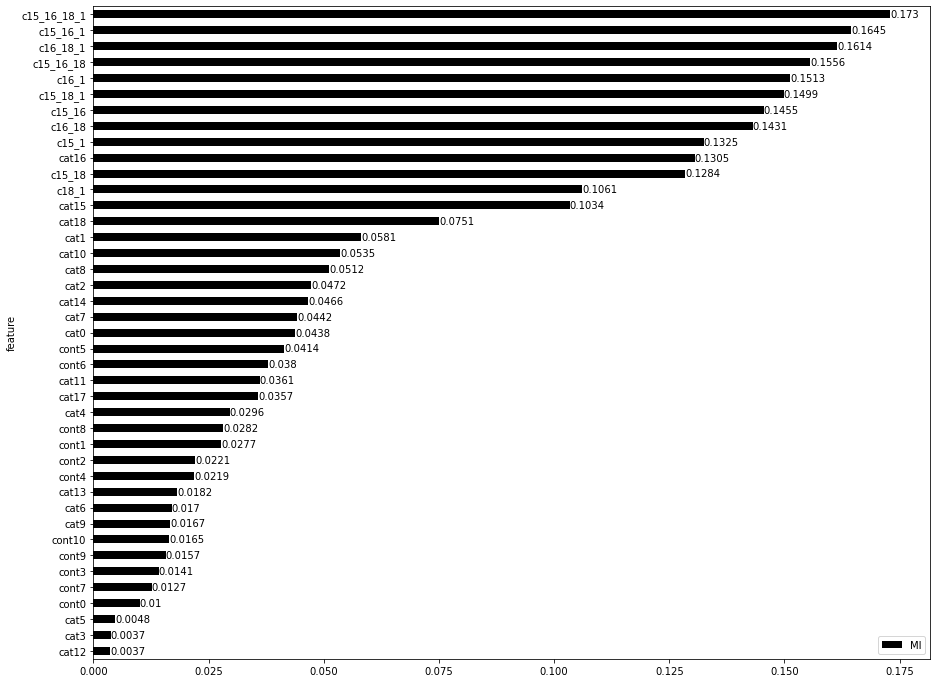

In [40]:
mi_mark_rare_F = mutual_info(data).copy()

<h3>All the newly added features have high MI scores, but their individual score is close to 0. Hence, adding them may not improve the model' performance to a great extent. However, adding them and employing a feature selection method might work.

<h2>Vanilla RF on data with newly added features

In [41]:
X,y = prepare_x_y(data)

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

rf = RandomForestClassifier(random_state=11)

#cv = cross_validate(estimator=rf,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc',return_train_score=True)

cv['train_score']<br>
array([1., 1., 1., 1., 1.])<br><br>

cv['test_score']<br>
array([0.88089911, 0.88598508, 0.88015966, 0.88502024, 0.88199494])<br>

np.mean(cv['test_score'])<br>
0.8828118051395147<br>

<h3>Adding New features has not improved the performance of the model. However, hyperparameter tuning may help

<h1><section id='build'>12. Model Building&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

<h1>Vanilla XGB

<h3>scale_pos_weight = no. of neg samples / no. of pos samples

In [42]:
# X = data.drop(columns=['target']).copy()
# y = data['target'].copy()

# col_transform = ColumnTransformer(transformers=[['ordinal_encoder',OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),categorical_variables]],
#                                    remainder='passthrough')

# X = col_transform.fit_transform(X).copy()

# kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

# final_model = xgb.XGBClassifier(random_state=11,
#                                 eval_metric='auc',
#                                 tree_method='gpu_hist',
#                                 n_jobs=-1,
#                                 use_label_encoder=False,
#                                 scale_pos_weight=2.78)

# # cv = cross_validate(estimator=final_model,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc',return_train_score=True)

cv['train_score']<br>
array([0.91757861, 0.91684923, 0.91634894, 0.91599782, 0.91700579])<br><br>

cv['test_score']<br>
array([0.88787838, 0.89218227, 0.88705092, 0.89156957, 0.8876197 ])<br>

np.mean(cv['test_score'])<br>
0.8892601661007467<br>

In [43]:
# final_model.fit(X,y)

<h2>Trying OptunaSearchCV (ExperimentalWarning: OptunaSearchCV is still experimental phase)

In [44]:
def model_train_test(X,y,estimator,param_distributions,n_trials,n_splits):
    
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=11)
    
    optuna_search = optuna.integration.OptunaSearchCV(estimator=estimator,
                                                  param_distributions=param_distributions,
                                                  cv=kfold,
                                                  scoring='roc_auc',
                                                  n_jobs=-1,
                                                  n_trials=n_trials,
                                                  random_state=11,
                                                  verbose=1)
    
    optuna_search.fit(X,y)
    
    result = {'optuna_search':optuna_search,
              'best_params':optuna_search.best_params_,
              'best_score':optuna_search.best_score_}
    
    return result

<h2>XGB + Optuna + RFE (Used as Final Model)

In [45]:
#scale_pos_weight = no. of neg samples / no. of pos samples

X = data.drop(columns=['target']).copy()
y = data['target'].copy()

col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
                                                 OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
                                                 categorical_variables]],
                                  remainder='passthrough')

X = col_transform.fit_transform(X).copy()

xgb_classifier = xgb.XGBClassifier(random_state=11,
                                   eval_metric='auc',
                                   tree_method='gpu_hist',
                                   n_jobs=-1,
                                   use_label_encoder=False,
                                   scale_pos_weight=2.8)


pipeline = Pipeline(steps=[['rfe',RFE(estimator=xgb_classifier)],
                           ['classifier',xgb_classifier]])




param_distributions = {'rfe__n_features_to_select':optuna.distributions.IntUniformDistribution(20, X.shape[1]),
                       'classifier__n_estimators':optuna.distributions.IntUniformDistribution(100, 700),
                       'classifier__max_depth':optuna.distributions.IntUniformDistribution(3, 15),
                       'classifier__reg_lambda':optuna.distributions.LogUniformDistribution(500, 100000),
                       'classifier__colsample_bylevel':optuna.distributions.LogUniformDistribution(0.5,1)
                      }

    
#result = model_train_test(X,y,pipeline,param_distributions,300,3)

#result

'best_params': {'rfe__n_features_to_select': 41,<br>
  'classifier__n_estimators': 670,<br>
  'classifier__max_depth': 10,<br>
  'classifier__reg_lambda': 9738.763400431715,<br>
  'classifier__colsample_bylevel': 0.6323793308207895},<br>
 'best_score': 0.8926917680409953}

In [46]:
X = data.drop(columns=['target']).copy()
y = data['target'].copy()

col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
                                                 OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
                                                 categorical_variables]],
                                  remainder='passthrough')

X = col_transform.fit_transform(X).copy()

xgb_classifier = xgb.XGBClassifier(random_state=11,
                                   eval_metric='auc',
                                   tree_method='gpu_hist',
                                   n_jobs=-1,
                                   use_label_encoder=False,
                                   scale_pos_weight=2.8,
                                   n_estimators=670,
                                   max_depth=10,
                                   reg_lambda=9738.763400431715,
                                   colsample_bylevel=0.6323793308207895)


final_model = Pipeline(steps=[['rfe',RFE(n_features_to_select=41,
                                         estimator=xgb.XGBClassifier(
                                         random_state=11,
                                         eval_metric='auc',
                                         tree_method='gpu_hist',
                                         n_jobs=-1,
                                         use_label_encoder=False,
                                         scale_pos_weight=2.8))],
                           ['classifier',xgb_classifier]])

final_model.fit(X,y)

Pipeline(steps=[('rfe',
                 RFE(estimator=XGBClassifier(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None,
                                             eval_metric='auc', gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             learning_rate=None,
                                             max_delta_step=None,
                                             max_depth=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=N...
                               interaction_constraints='',
              

<h2>LGBMClassifier using same hyperparameters tuned for XGB (Need to train)

In [47]:
# #scale_pos_weight = no. of neg samples / no. of pos samples

# X = data.drop(columns=['target']).copy()
# y = data['target'].copy()

# col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
#                                                  OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
#                                                  categorical_variables]],
#                                   remainder='passthrough')

# X = col_transform.fit_transform(X).copy()

# lgb_classifier = LGBMClassifier(random_state=11,
#                                 metric='auc',
#                                 device_type='gpu',
#                                 n_jobs=-1,
#                                 scale_pos_weight=2.8)


# pipeline = Pipeline(steps=[['rfe',RFE(estimator=lgb_classifier)],
#                            ['classifier',lgb_classifier]])




# param_distributions = {'rfe__n_features_to_select':optuna.distributions.IntUniformDistribution(10, X.shape[1]),
#                        'classifier__n_estimators':optuna.distributions.IntUniformDistribution(100, 700),
#                        'classifier__max_depth':optuna.distributions.IntUniformDistribution(2, 15),
#                        'classifier__reg_lambda':optuna.distributions.LogUniformDistribution(500, 100000),
#                        'classifier__feature_fraction_bynode':optuna.distributions.LogUniformDistribution(0.5,1)
#                       }

    
# #result = model_train_test(X,y,pipeline,param_distributions,150,3)

# #result

<h2>VotingClassifier (Not yet trained)

In [48]:
# X = data.drop(columns=['target']).copy()
# y = data['target'].copy()

# col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
#                                                  OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
#                                                  categorical_variables]],
#                                   remainder='passthrough')

# X = col_transform.fit_transform(X).copy()


# xgb_model = xgb.XGBClassifier(random_state=11,
#                                    eval_metric='auc',
#                                    tree_method='gpu_hist',
#                                    n_jobs=-1,
#                                    use_label_encoder=False,
#                                    scale_pos_weight=2.8,
#                                    n_estimators=636,
#                                    max_depth=8,
#                                    reg_lambda=10495.566650340597,
#                                    colsample_bylevel=0.8940079532042917)

# lgb_model = LGBMClassifier(random_state=11,
#                                 metric='auc',
#                                 device_type='gpu',
#                                 n_jobs=-1,
#                                 scale_pos_weight=2.8,
#                                 n_estimators=550,
#                                 max_depth=13,
#                                 num_leaves = 2^(13),
#                                 reg_lambda=789.5237167418961,
#                                 feature_fraction_bynode=0.6711243271129161
#                                )

# voting_classifier = VotingClassifier(estimators = [('xgb',xgb_model),('lgb',lgb_model)],
#                                     voting='soft')

# voting_classifier.fit(X,y)

In [49]:
# final_model = voting_classifier

<h2>EasyEnsembleClassifier (no improvement in submission score)

In [50]:
# X = data.drop(columns=['target']).copy()
# y = data['target'].copy()

# col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
#                                                  OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
#                                                  categorical_variables]],
#                                   remainder='passthrough')

# X = col_transform.fit_transform(X).copy()

# xgb_classifier = xgb.XGBClassifier(random_state=11,
#                                    eval_metric='auc',
#                                    tree_method='gpu_hist',
#                                    n_jobs=-1,
#                                    use_label_encoder=False,
#                                    n_estimators=636,
#                                    max_depth=8,
#                                    reg_lambda=10495.566650340597,
#                                    colsample_bylevel=0.8940079532042917)

# kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=11)

# model = EasyEnsembleClassifier(base_estimator = xgb_classifier,
#                                random_state=11,
#                                verbose=11,
#                                n_jobs=-1)
    
# cv = cross_validate(estimator=model,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc',return_train_score=True)
    
    
# print(f'\ntrain_scores\n{cv["train_score"]}\nmean train score\n{np.mean(cv["train_score"])}' + 
#      f'\ntest_scores\n{cv["test_score"]}\nmean test score\n{np.mean(cv["test_score"])}')


train_scores
[0.90357855 0.90318018 0.90274322 0.90319348 0.90365007 0.90314774
 0.90269818 0.90347099 0.90326053 0.90343125]<br><br>
mean train score<br>
0.9032354202610001<br><br>
test_scores<br>
[0.88959868 0.89332921 0.8974062  0.89291028 0.88805739 0.8933892
 0.89770895 0.89028771 0.89207586 0.89045199]<br><br>
mean test score<br>
0.892521546427905



In [51]:
# final_model = EasyEnsembleClassifier(base_estimator = xgb_classifier,
#                                random_state=11,
#                                verbose=11,
#                                n_jobs=-1)

# final_model.fit(X,y)

<h2>Evaluating few under-sampling techniques (Not yet trained)

In [52]:
# X = data.drop(columns=['target']).copy()
# y = data['target'].copy()

# col_transform = ColumnTransformer(transformers=[['ordinal_encoder',
#                                                  OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1),
#                                                  categorical_variables]],
#                                   remainder='passthrough')

# X = col_transform.fit_transform(X).copy()

# xgb_classifier = xgb.XGBClassifier(random_state=11,
#                                    eval_metric='auc',
#                                    tree_method='gpu_hist',
#                                    n_jobs=-1,
#                                    use_label_encoder=False,
#                                    n_estimators=426,
#                                    max_depth=7,
#                                    reg_lambda=4905.085039913591)

# under_samplers = [under_sampling.TomekLinks(n_jobs=-1),
#                   under_sampling.CondensedNearestNeighbour(random_state=11,n_jobs=-1),
#                   under_sampling.EditedNearestNeighbours(n_jobs=-1),
#                   under_sampling.RepeatedEditedNearestNeighbours(n_jobs=-1),
#                   under_sampling.NearMiss(n_jobs=-1),
#                   under_sampling.NeighbourhoodCleaningRule(n_jobs=-1)]

# for i in under_samplers:
    
#     kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=11)
    
    
#     model = imbpipeline(steps=[['under_sampler',i],
#                                ['classifier',xgb_classifier]])
    
#     cv = cross_validate(estimator=model,X=X,y=y,cv=kfold,n_jobs=-1,verbose=11,scoring='roc_auc')
    
    
#     print(f'{i}\ntest_scores\n{cv["test_score"]}\nmean test score\n{np.mean(cv["test_score"])}')



<h1>WORK IN PROGRESS

<h1><section id='subm'>13. Submission&nbsp;&nbsp;<a href=#top>Top</a></section></h1>

In [53]:
test = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')

In [54]:
test_ids = test['id'].copy()

In [55]:
test.drop(columns='id',inplace=True)

In [56]:
test.dtypes

cat0       object
cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
cat6       object
cat7       object
cat8       object
cat9       object
cat10      object
cat11      object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cont0     float64
cont1     float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     float64
cont7     float64
cont8     float64
cont9     float64
cont10    float64
dtype: object

In [57]:
categorical_variables = list(test.select_dtypes('object').columns)

numeric_variables = list(test.select_dtypes('float64').columns)

In [58]:
print(f'Categorical Variables ({len(categorical_variables)}):\n{categorical_variables}\n\nNumeric Variables ({len(numeric_variables)}):\n{numeric_variables}')

Categorical Variables (19):
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

Numeric Variables (11):
['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']


In [59]:
test['c15_16'] = test['cat15'] + '-' + test['cat16']
test['c15_18'] = test['cat15'] + '-' +  test['cat18']
test['c16_18'] = test['cat16'] + '-' +  test['cat18']
test['c15_16_18'] = test['cat15'] + '-' +  test['cat16'] + '-' +  test['cat18']

#NEW
test['c15_1'] = test['cat15'] + '-' + test['cat1']
test['c16_1'] = test['cat16'] + '-' + test['cat1']
test['c18_1'] = test['cat18'] + '-' + test['cat1']

test['c15_16_1'] = test['cat15'] +  '-' + test['cat16'] + '-' + test['cat1']
test['c15_18_1'] = test['cat15'] +  '-' + test['cat18'] + '-' + test['cat1']
test['c16_18_1'] = test['cat16'] +  '-' + test['cat18'] + '-' + test['cat1']
test['c15_16_18_1'] = test['cat15'] +  '-' + test['cat16'] +  '-' + test['cat18'] + '-' + test['cat1']

In [60]:
test.head().T

,0,1,2,3,4
cat0,A,A,A,B,A
cat1,F,H,N,L,F
cat2,A,C,C,C,A
cat3,A,A,A,A,B
cat4,F,E,F,F,F
cat5,BI,AB,AB,BI,BI
cat6,A,I,A,A,A
cat7,AH,F,AH,E,AH
cat8,AX,N,BC,AX,I
cat9,A,A,A,A,A


In [61]:
#categorical_variables.extend(['c15_16','c15_18','c16_18','c15_16_18'])
categorical_variables.extend(['c15_16','c15_18','c16_18','c15_16_18','c15_1','c16_1','c18_1',
                              'c15_16_1','c15_18_1','c16_18_1','c15_16_18_1'])

<h3>Count of rows in test data with categories not in training data

In [62]:
for i in categorical_variables:
    print(f'{i}\n{np.sum(test[i].isin(data[i])==False)}')

cat0
0
cat1
0
cat2
0
cat3
0
cat4
0
cat5
0
cat6
0
cat7
0
cat8
0
cat9
0
cat10
10
cat11
0
cat12
0
cat13
0
cat14
0
cat15
0
cat16
0
cat17
0
cat18
0
c15_16
0
c15_18
0
c16_18
0
c15_16_18
0
c15_1
0
c16_1
0
c18_1
0
c15_16_1
8
c15_18_1
3
c16_18_1
4
c15_16_18_1
70


In [63]:
test.dtypes

cat0            object
cat1            object
cat2            object
cat3            object
cat4            object
cat5            object
cat6            object
cat7            object
cat8            object
cat9            object
cat10           object
cat11           object
cat12           object
cat13           object
cat14           object
cat15           object
cat16           object
cat17           object
cat18           object
cont0          float64
cont1          float64
cont2          float64
cont3          float64
cont4          float64
cont5          float64
cont6          float64
cont7          float64
cont8          float64
cont9          float64
cont10         float64
c15_16          object
c15_18          object
c16_18          object
c15_16_18       object
c15_1           object
c16_1           object
c18_1           object
c15_16_1        object
c15_18_1        object
c16_18_1        object
c15_16_18_1     object
dtype: object

In [64]:
test = col_transform.transform(test).copy()

In [65]:
prediction = final_model.predict_proba(test)[:,1]

In [66]:
submission = pd.DataFrame({'id':test_ids,'target':prediction})

In [67]:
submission

,id,target
0,5,0.218475
1,6,0.694223
2,8,0.033831
3,9,0.439244
4,11,0.230922
...,...,...
199995,499983,0.972154
199996,499984,0.107654
199997,499987,0.814913
199998,499994,0.209621


In [68]:
submission.to_csv('submission_11.csv',index=False)